In [1]:
# --- 1. IMPORTS & SETUP ---
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score 

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

# Locate Image Directory
IMG_DIR = None
for root, dirs, files in os.walk('/kaggle/input'):
    if sum(1 for f in files if f.endswith('.jpg')) > 100:
        IMG_DIR = root
        break

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


Using Device: cuda


Loading Data...


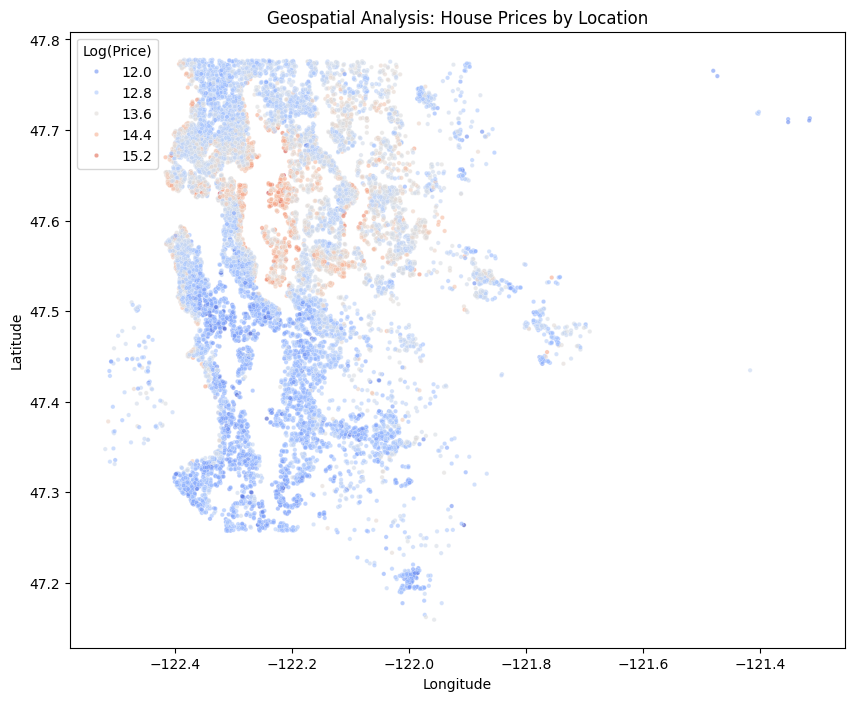

Observation: High prices (Red) are clustered around water bodies and specific northern neighborhoods.


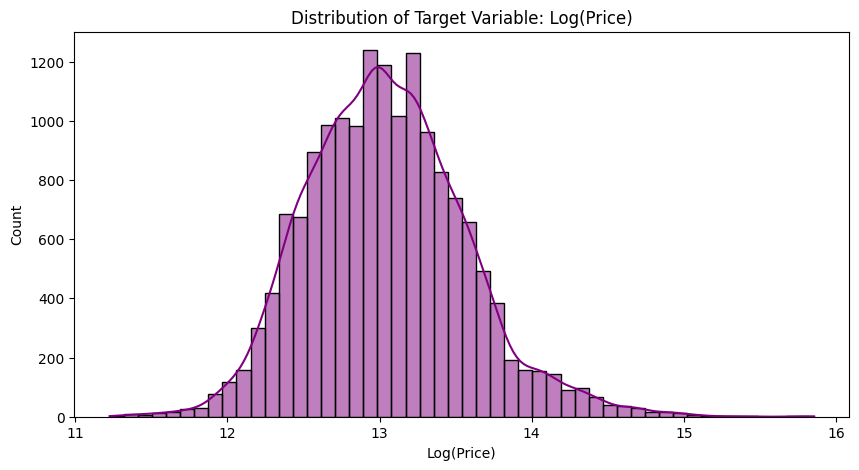

Observation: Log-transforming the price fixes the heavy right-skew, making it Gaussian-like.


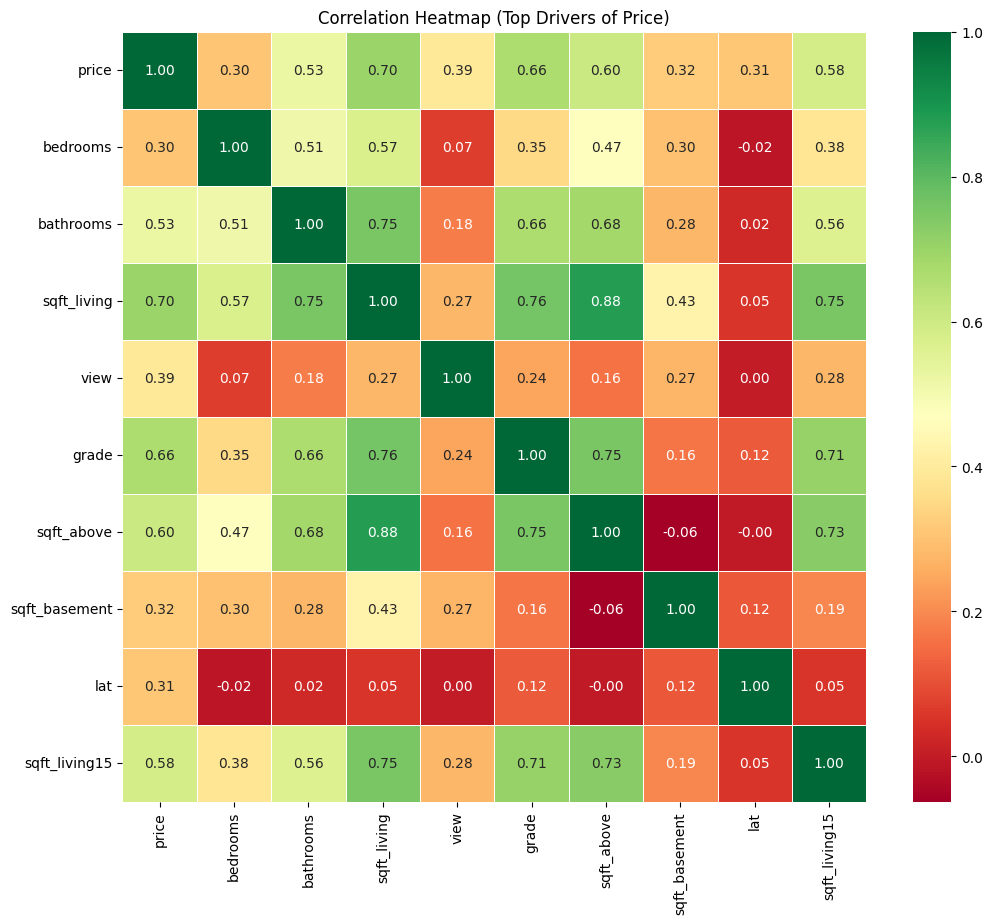

/tmp/ipykernel_55/3164306868.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_train['grade'], y=np.log1p(df_train['price']), palette='viridis')


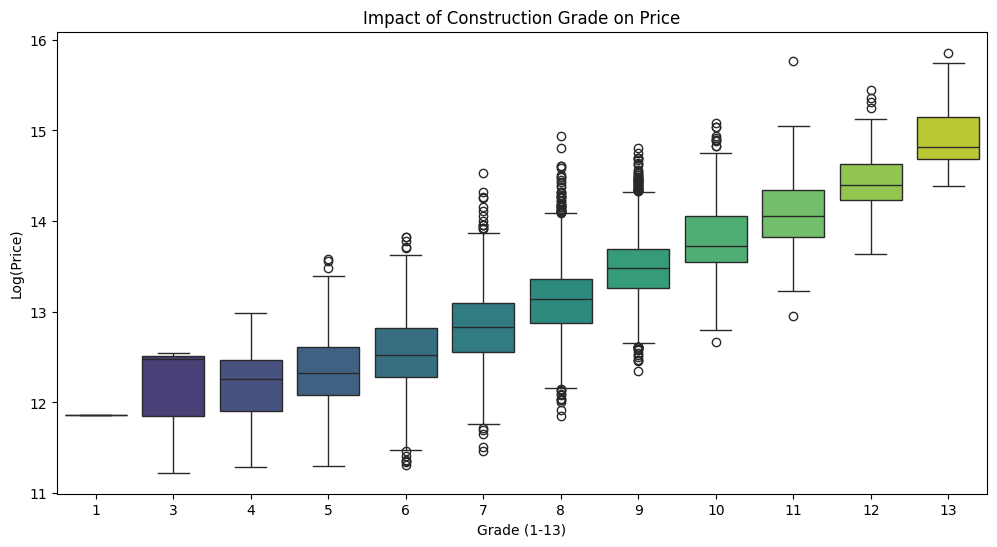

Observation: There is a clear exponential relationship between construction Grade and Price.


/tmp/ipykernel_55/3164306868.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_train['waterfront'], y=np.log1p(df_train['price']), palette='cool')


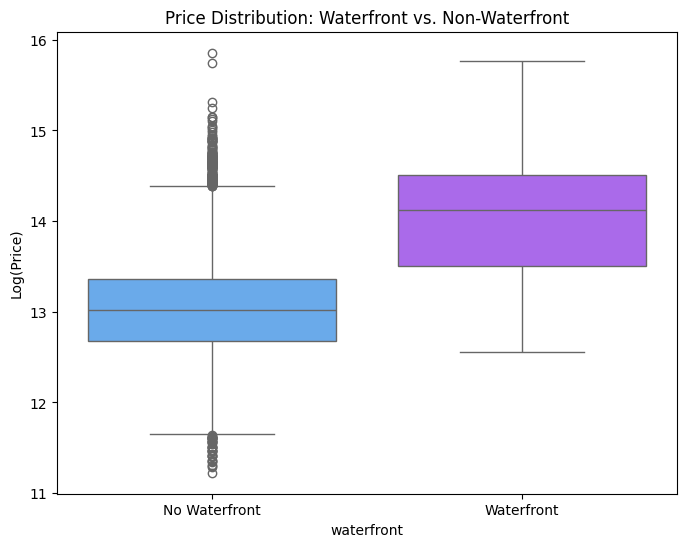

Observation: Waterfront properties have a significantly higher median price and different distribution.


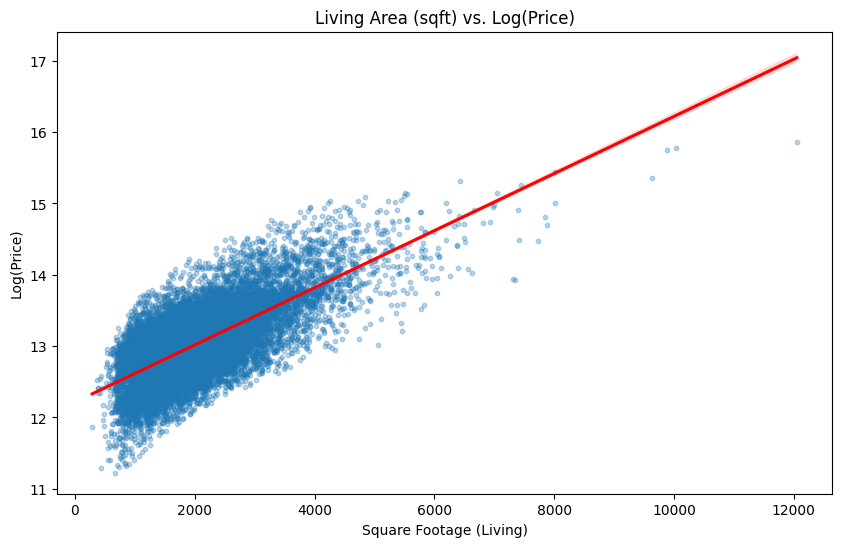

Observation: Strong linear relationship. As size increases, price increases consistently.


/tmp/ipykernel_55/3164306868.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='condition', y='price', data=avg_price_by_cond, palette='Blues_d')


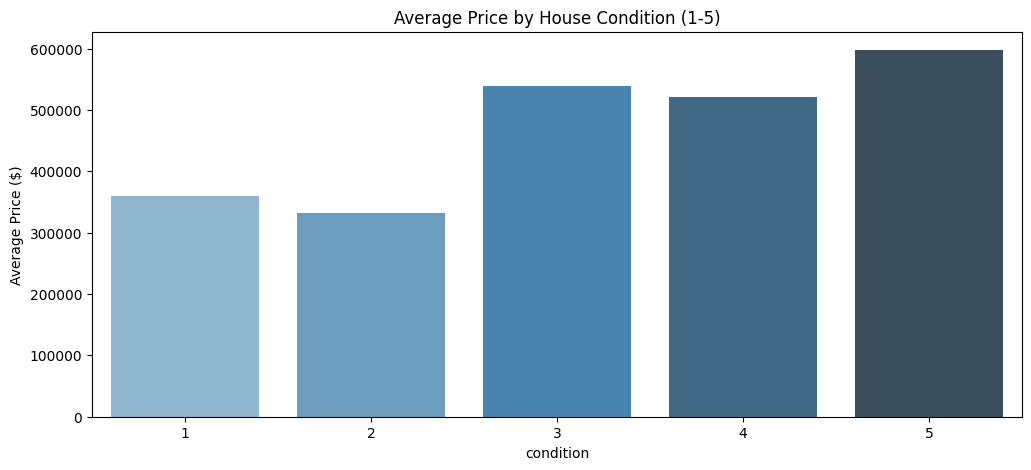

Observation: Surprisingly, condition 3, 4, and 5 often have similar average prices, but condition 1-2 are much lower.


In [2]:
# --- 2. DATA LOADING & GEOSPATIAL EDA ---
print("Loading Data...")
df_train = pd.read_excel('/kaggle/input/cdcpro/train(1).xlsx')
df_test = pd.read_excel('/kaggle/input/cdcpro/test2.xlsx')
full_df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# 2.1 Geospatial Plot
# We plot Latitude vs Longitude, colored by Price (Log scale for visibility)
plt.figure(figsize=(10, 8))
plt.title("Geospatial Analysis: House Prices by Location")
sns.scatterplot(
    x=df_train['long'], 
    y=df_train['lat'], 
    hue=np.log1p(df_train['price']), 
    palette='coolwarm', 
    alpha=0.6,
    s=10
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Log(Price)")
plt.show()

print("Observation: High prices (Red) are clustered around water bodies and specific northern neighborhoods.")

# --- NEW ADDITIONS BELOW ---

# 2.2 Price Distribution (Checking for Skewness)
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df_train['price']), kde=True, bins=50, color='purple')
plt.title("Distribution of Target Variable: Log(Price)")
plt.xlabel("Log(Price)")
plt.show()
print("Observation: Log-transforming the price fixes the heavy right-skew, making it Gaussian-like.")

# 2.3 Feature Correlation Heatmap
plt.figure(figsize=(12, 10))
# Select only numeric columns to avoid errors
numeric_df = df_train.select_dtypes(include=[np.number])
# Calculate correlation matrix
corr_matrix = numeric_df.corr()
# Filter to show only features that correlate strongly with Price (> 0.3 or < -0.3)
top_features = corr_matrix.index[abs(corr_matrix["price"]) > 0.3]
sns.heatmap(df_train[top_features].corr(), annot=True, cmap='RdYlGn', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Top Drivers of Price)")
plt.show()

# 2.4 House Grade vs. Price (Box Plot)
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_train['grade'], y=np.log1p(df_train['price']), palette='viridis')
plt.title("Impact of Construction Grade on Price")
plt.xlabel("Grade (1-13)")
plt.ylabel("Log(Price)")
plt.show()
print("Observation: There is a clear exponential relationship between construction Grade and Price.")

# 2.5 Waterfront Impact (Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_train['waterfront'], y=np.log1p(df_train['price']), palette='cool')
plt.title("Price Distribution: Waterfront vs. Non-Waterfront")
plt.xticks([0, 1], ['No Waterfront', 'Waterfront'])
plt.ylabel("Log(Price)")
plt.show()
print("Observation: Waterfront properties have a significantly higher median price and different distribution.")

# 2.6 Living Area vs. Price (Scatter with Regression Line)
plt.figure(figsize=(10, 6))
sns.regplot(x=df_train['sqft_living'], y=np.log1p(df_train['price']), scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})
plt.title("Living Area (sqft) vs. Log(Price)")
plt.xlabel("Square Footage (Living)")
plt.ylabel("Log(Price)")
plt.show()
print("Observation: Strong linear relationship. As size increases, price increases consistently.")

# 2.7 Condition vs. Age (Bar Plot)
plt.figure(figsize=(12, 5))
avg_price_by_cond = df_train.groupby('condition')['price'].mean().reset_index()
sns.barplot(x='condition', y='price', data=avg_price_by_cond, palette='Blues_d')
plt.title("Average Price by House Condition (1-5)")
plt.ylabel("Average Price ($)")
plt.show()
print("Observation: Surprisingly, condition 3, 4, and 5 often have similar average prices, but condition 1-2 are much lower.")

In [3]:
# --- 3. TABULAR FEATURE ENGINEERING ---
full_df['date'] = pd.to_datetime(full_df['date'])
full_df['sale_year'] = full_df['date'].dt.year
full_df['sale_month'] = full_df['date'].dt.month
full_df['house_age'] = full_df['sale_year'] - full_df['yr_built']

# Create bins for "Micro-Neighborhoods"
full_df['lat_bin'] = (full_df['lat'] // 0.02).astype(int)
full_df['long_bin'] = (full_df['long'] // 0.02).astype(int)

# Feature: Neighborhood Density (Average size of nearby houses)
full_df['neighborhood_density'] = full_df.groupby(['lat_bin', 'long_bin'])['sqft_living'].transform('mean')

# Feature: Neighborhood Price Grade
full_df['neighborhood_price_grade'] = full_df.groupby(['zipcode'])['grade'].transform('mean')

full_df['id'] = full_df['id'].astype(str)

Initializing Grad-CAM Model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 76.9MB/s]


Found sample image for explanation: 2141300080.0.jpg


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


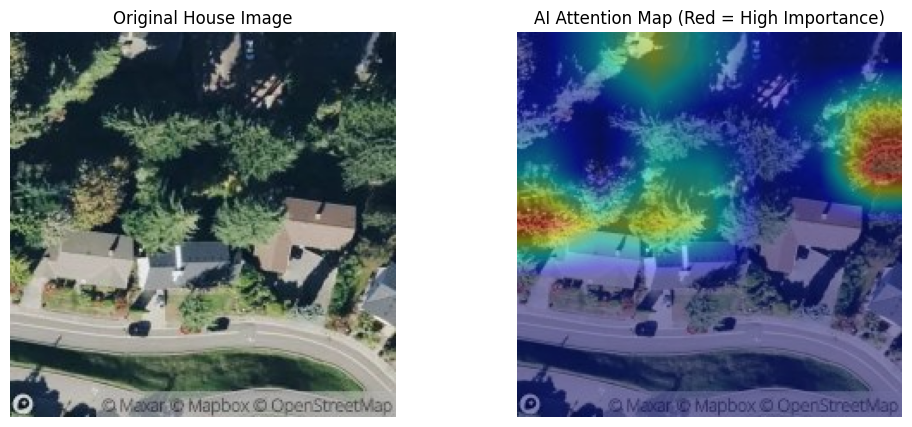

Explanation: The Red/Yellow areas show which parts of the image (e.g., greeneries/roof) the CNN focused on to generate the embedding.


In [4]:
# --- 4. MODEL EXPLAINABILITY (GRAD-CAM) ---
# Helper function to process image
def get_image_tensor(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0).to(DEVICE), img

# Hook-based Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        
        target = output[:, 0] 
        target.backward()
        
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
            
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Load Model for Visualization
print("Initializing Grad-CAM Model...")
cam_model = models.efficientnet_b0(pretrained=True).to(DEVICE)
cam_model.eval()

# Target the last convolutional layer in EfficientNet
target_layer = cam_model.features[-1] 
grad_cam = GradCAM(cam_model, target_layer)

found_image = False
img_path = ""

if IMG_DIR and os.path.exists(IMG_DIR):
    # List files and pick the first JPG found
    files = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(files) > 0:
        img_path = os.path.join(IMG_DIR, files[0]) # Pick the first available image
        found_image = True
        print(f"Found sample image for explanation: {files[0]}")
    else:
        print(f"Error: No images found in directory {IMG_DIR}")
else:
    print("Error: IMG_DIR not found.")

if found_image:
    input_tensor, original_img = get_image_tensor(img_path)
    heatmap = grad_cam(input_tensor)
    
    # Overlay heatmap on image
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Resize original image to match heatmap (224x224)
    original_img = original_img.resize((224, 224))
    superimposed = np.uint8(0.6 * np.array(original_img) + 0.4 * heatmap)

    # Plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original House Image")
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("AI Attention Map (Red = High Importance)")
    plt.imshow(superimposed)
    plt.axis('off')
    
    plt.show()
    print("Explanation: The Red/Yellow areas show which parts of the image (e.g., greeneries/roof) the CNN focused on to generate the embedding.")
else:
    print("Skipping Grad-CAM visualization due to missing images.")

In [5]:
# --- 5. VISUAL FEATURE EXTRACTION ---

# Define Dataset
class FeatureExtractionDataset(Dataset):
    def __init__(self, dataframe, image_dir):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, f"{str(row['id'])}.jpg")
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except:
            image = torch.zeros((3, 224, 224)) 
        return image, row['id']

# Load Model (Identity Head)
model = models.efficientnet_b0(pretrained=True).to(DEVICE)
model.classifier = nn.Identity()
model.eval()

dataset = FeatureExtractionDataset(full_df[['id']], IMG_DIR)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

print("Extracting Visual Features...")
features_list = []
ids_list = []

with torch.no_grad():
    for imgs, batch_ids in tqdm(loader):
        imgs = imgs.to(DEVICE)
        embeddings = model(imgs)
        features_list.append(embeddings.cpu().numpy())
        ids_list.extend(batch_ids)

all_features = np.vstack(features_list)
feat_cols = [f'img_{i}' for i in range(all_features.shape[1])]
img_df = pd.DataFrame(all_features, columns=feat_cols)
img_df['id'] = ids_list

Extracting Visual Features...


100%|██████████| 338/338 [00:22<00:00, 15.34it/s]


In [6]:
# --- 6. FUSION ARCHITECTURE & PCA ---

# Merge Tabular + Visual
print("Performing Late Fusion (Merging Data)...")
img_df['id'] = img_df['id'].astype(str)
img_df = img_df.drop_duplicates(subset=['id'])
merged_df = pd.merge(full_df, img_df, on='id', how='left')

# PCA Compression
print("Reducing Dimensions (1280 -> 50)...")
img_cols = [c for c in img_df.columns if c.startswith('img_')]
pca = PCA(n_components=50, random_state=42)
pca_features = pca.fit_transform(merged_df[img_cols].fillna(0))

pca_cols = [f'pca_img_{i}' for i in range(50)]
pca_df = pd.DataFrame(pca_features, columns=pca_cols)

merged_df = merged_df.drop(columns=img_cols)
merged_df = pd.concat([merged_df, pca_df], axis=1)

Performing Late Fusion (Merging Data)...
Reducing Dimensions (1280 -> 50)...


In [7]:
# --- 7. OPTUNA TUNING ---

# 7.1 Define Features
tab_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
                'lat', 'long', 'sqft_living15', 'sqft_lot15',
                'house_age', 'sale_month', 'lat_bin', 'long_bin', 
                'neighborhood_density', 'neighborhood_price_grade']
all_features = tab_features + pca_cols

# 7.2 Split Data
train_data = merged_df[merged_df['price'].notna()]
test_data = merged_df[merged_df['price'].isna()]

X = train_data[all_features]
y = np.log1p(train_data['price']) 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',      
        'device': 'cuda',           
        'n_estimators': trial.suggest_int('n_estimators', 2000, 6000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'n_jobs': -1,
        'random_state': 42,
        'early_stopping_rounds': 100
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    preds = model.predict(X_val)
    return r2_score(y_val, preds)

# 7.4 Run Study
print("Starting Optuna Optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) 

print("Best Params Found:", study.best_params)
best_params = study.best_params

[I 2026-01-10 15:51:58,303] A new study created in memory with name: no-name-d9ed5018-9bc8-457e-b6cb-a0172529ea19


Starting Optuna Optimization...


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [15:52:03] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2026-01-10 15:52:03,292] Trial 0 finished with value: 0.9015425716919991 and parameters: {'n_estimators': 2237, 'learning_rate': 0.006546374624642644, 'max_depth': 5, 'subsample': 0.7077661216491422, 'colsample_bytree': 0.6817558290462891, 'reg_alpha': 8.410334245752667, 'reg_lambda': 0.30613378128784174}. Best is trial 0 with value: 0.9015425716919991.
[I 2026-01-10 15:52:06,397] Trial 1 finished with value: 0.9091981561515381 and parameters: {'n_

Best Params Found: {'n_estimators': 4817, 'learning_rate': 0.03366183440417996, 'max_depth': 7, 'subsample': 0.8137858758439711, 'colsample_bytree': 0.6385153819391848, 'reg_alpha': 0.049103115262716775, 'reg_lambda': 3.473935044769375}


In [8]:
# --- 7. HYPERPARAMETER TUNING & TRAINING ---

tab_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
                'lat', 'long', 'sqft_living15', 'sqft_lot15',
                'house_age', 'sale_month', 'lat_bin', 'long_bin', 
                'neighborhood_density', 'neighborhood_price_grade']
all_features = tab_features + pca_cols

train_data = merged_df[merged_df['price'].notna()]
test_data = merged_df[merged_df['price'].isna()]

X = train_data[all_features]
y = np.log1p(train_data['price'])
X_test = test_data[all_features]


# 5-Fold Ensemble
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds_sum = np.zeros(len(X_test))

print("Starting 5-Fold Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
    
    val_pred = model.predict(X_val_fold)
    oof_preds[val_idx] = val_pred
    test_preds_sum += model.predict(X_test)
    
    # Calculate Fold Metrics
    fold_r2 = r2_score(y_val_fold, val_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, val_pred))
    
    print(f"Fold {fold+1} R2: {fold_r2:.5f} | RMSE: {fold_rmse:.5f}")

# Calculate Overall Metrics
overall_r2 = r2_score(y, oof_preds)
overall_rmse = np.sqrt(mean_squared_error(y, oof_preds))

print(f"\nOverall CV Score - R2: {overall_r2:.5f} | RMSE: {overall_rmse:.5f}")

# Submission Generation
final_preds_log = test_preds_sum / 5
final_preds_real = np.expm1(final_preds_log)
submission = pd.DataFrame({
    'id': test_data['id'], 
    'price': final_preds_real
})
submission.to_csv('submission_final.csv', index=False)

Starting 5-Fold Cross-Validation...
Fold 1 R2: 0.90427 | RMSE: 0.16254
Fold 2 R2: 0.90439 | RMSE: 0.15971
Fold 3 R2: 0.91148 | RMSE: 0.16096
Fold 4 R2: 0.90271 | RMSE: 0.16237
Fold 5 R2: 0.90201 | RMSE: 0.16127

Overall CV Score - R2: 0.90511 | RMSE: 0.16137
